# En este notebook se analiza el comportamiento de los diferentes grupos de postulantes de a cuerdo a sus edades. 
## Para esto se toman 3 grupos de postulantes: 
### - Los menores de 23 años (18 - 24 años).
### - Los que se encuentran entre 25 años y 34 años inclusive (23 - 34 años).
### - Los mayores de 35 años.

In [1]:
# Se importan las librerías necesarias.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as datetime
import sys
reload(sys) # now sys.setdefaultencoding() is visible
sys.setdefaultencoding('utf-8')
%run double-pendulum.py

pd.options.mode.chained_assignment = None

In [2]:
# Se leen los dataframes.
postulantesEducacion = pd.read_csv('../Data/fiuba_1_postulantes_educacion.csv')
postulantesGeneroYEdad = pd.read_csv('../Data/fiuba_2_postulantes_genero_y_edad.csv')
oportunidadVistas = pd.read_csv('../Data/fiuba_3_vistas.csv')
oportunidadPostulaciones = pd.read_csv('../Data/fiuba_4_postulaciones.csv')
avisosOnline = pd.read_csv('../Data/fiuba_5_avisos_online.csv')
avisosDetalle = pd.read_csv('../Data/fiuba_6_avisos_detalle.csv')

In [3]:
# Elimino los postulantes cuyos ids o fechas de nacimiento son nulas.

# Elimino las filas que no tengan id del postulante.
postulantesEducacion.dropna(subset = ['idpostulante'], inplace = True)
postulantesGeneroYEdad.dropna(subset = ['idpostulante'], inplace = True)

# Creo un nuevo dataframe con los postulantes que tengan fecha de nacimiento.
postulantesConEdad = postulantesGeneroYEdad.dropna(subset=['fechanacimiento'])

In [4]:
# Creo una nueva columna con la edad del postulante. Descarto los postulantes cuyas edades no pueden ser averiguadas.

# Paso la columna fecha de nacimiento a un datetime.
postulantesConEdad['fechanacimiento'] = pd.to_datetime(postulantesConEdad['fechanacimiento'], errors='coerce')

# Creo la columna edad como diferencia entre la fecha actual y la fecha de nacimiento.
fechaActual = pd.Timestamp(datetime.datetime.now())
postulantesConEdad['edad'] = (fechaActual - postulantesConEdad['fechanacimiento']).astype('<m8[Y]')

# Elimino los postulantes sin edades.
postulantesConEdad.dropna(subset = ['edad'], inplace = True)

# Descarto la columna fecha de nacimiento.
postulantesConEdad.drop('fechanacimiento', 1, inplace = True)

In [5]:
# Creo un unico dataframe para los datos del postulante.

# Renombro las columnas del dataframe de educacion a algo mas descriptivo.
postulantesEducacion.rename(columns={'nombre': 'niveleducativo', 'estado': 'estadoniveleducation'}, inplace = True)

# Hago un left join tomando todos los registros del dataframe que contiene la edad.
postulantes = pd.merge(postulantesConEdad, postulantesEducacion, on = 'idpostulante', how = 'left')

# Tomo los campos relacionado a lo educativo, los uno en uno solo y elimino las dos columnas no necesarias.
postulantes['educacion'] = postulantes['niveleducativo'] + '-' + postulantes['estadoniveleducation']
postulantes.drop('niveleducativo', 1, inplace = True)
postulantes.drop('estadoniveleducation', 1, inplace = True)

In [6]:
# Agrego al dataframe de detalles de aviso una columna que diga especifique si sigue online o esta offline.

# Agrego una columna booleana al avisos online para que despues quede en el left merge.
avisosOnline['online'] = True

# Hago el merge entre los detalles y la tabla de online, luego completo los Nan de los offline con False.
avisos = pd.merge(avisosDetalle, avisosOnline, on = 'idaviso', how = 'left')
avisos['online'].fillna(False, inplace = True)

# Teniendo los dataframe de avisos, postulantes, vistas de aviso y postulaciones de aviso se procede a dar respuestas a las siguientes preguntas:

### 1) ¿Cuáles son las areas de trabajo mas visitadas por los diferentes grupos? ¿Y las menos visitadas?
### 2) ¿Cuáles son las areas de trabajo que reciben mas postulaciones de los diferentes grupos?

## Antes de empezar a responder las diferentes preguntas vamos a hacer un análisis demográfico de cada grupo:
- Cuantos postulantes hay en cada grupo.
- Como se conforman los diferentes grupos en cuanto a sexo.
- Cual es el nivel educacional de cada grupo y de cada grupo dividido por sexo.

In [7]:
# TODO: Gastón - Aca va el análisis demográfico.

### Antes de empezar a responder las preguntas creo los dataframe que voy a estar utilizando en el desarrollo de las mismas.

In [21]:
# Renombro la columna idAviso de las vistas a idaviso sin mayuscula así queda homogeneo.
oportunidadVistas.rename(columns={'idAviso': 'idaviso'}, inplace = True)

# Dataframe de vistas.
vistas = pd.merge(oportunidadVistas, avisos, on = 'idaviso', how = 'left')
vistas = pd.merge(vistas, postulantes, on = 'idpostulante', how = 'left')

# Dataframe de postulaciones.
postulaciones = pd.merge(oportunidadPostulaciones, avisos, on = 'idaviso', how = 'left')
postulaciones = pd.merge(vistas, postulantes, on = 'idpostulante', how = 'left')

In [52]:
# 1) ¿Cuáles son las areas de trabajo mas visitadas por los diferentes grupos? ¿Y las menos visitadas?

# Tomo del dataframe de vistas el nombre de area y la edad solamente.
areaVisitadas = vistas[['nombre_area', 'edad']]

# Agrego una columna cantidad para que luego haga las veces de contador en el group by.
areaVisitadas['cantidad'] = 1

# Divido el dataframe en los 3 grupos de edades.
areaVisitadas1 = areaVisitadas[areaVisitadas['edad'] < 25]
areaVisitadas1.drop('edad', 1, inplace = True)

areaVisitadas2 = areaVisitadas[(areaVisitadas['edad'] >= 25) & (areaVisitadas['edad'] < 35)]
areaVisitadas2.drop('edad', 1, inplace = True)

areaVisitadas3 = areaVisitadas[areaVisitadas['edad'] >= 35]
areaVisitadas3.drop('edad', 1, inplace = True)

# Agrupo segun el area.
areaVisitadas1 = areaVisitadas1.groupby(['nombre_area'], as_index = False).count()
areaVisitadas2 = areaVisitadas2.groupby(['nombre_area'], as_index = False).count()
areaVisitadas3 = areaVisitadas3.groupby(['nombre_area'], as_index = False).count()

# Ordeno de mayor a menor.
areaVisitadas1 = areaVisitadas1.sort_values(by = 'cantidad', ascending = False)
areaVisitadas2 = areaVisitadas2.sort_values(by = 'cantidad', ascending = False)
areaVisitadas3 = areaVisitadas3.sort_values(by = 'cantidad', ascending = False)

# Tomo las 10 areas mas visitadas y las menos visitadas de cada grupo.
areaMasVisitadas1 = areaVisitadas1.head(10)
areaMenosVisitadas1 = areaVisitadas1.tail(10)

areaMasVisitadas2 = areaVisitadas2.head(10)
areaMenosVisitadas2 = areaVisitadas2.tail(10)

areaMasVisitadas3 = areaVisitadas3.head(10)
areaMenosVisitadas3 = areaVisitadas3.tail(10)

In [53]:
areaMasVisitadas1

,nombre_area,cantidad
149,Ventas,74710
2,Administración,50579
123,Recepcionista,33343
13,Atención al Cliente,28784
24,Comercial,24378
21,Call Center,19742
116,Producción,19357
142,Telemarketing,18249
143,Tesorería,11662
22,Camareros,8766


In [54]:
areaMasVisitadas2

,nombre_area,cantidad
2,Administración,84596
155,Ventas,79925
24,Comercial,43128
121,Producción,39610
13,Atención al Cliente,35380
128,Recepcionista,32843
21,Call Center,21875
149,Tesorería,17950
36,Contabilidad,15237
129,Recursos Humanos,15047


In [55]:
areaMasVisitadas3

,nombre_area,cantidad
2,Administración,34746
155,Ventas,33742
24,Comercial,23721
119,Producción,20165
13,Atención al Cliente,12384
126,Recepcionista,12082
127,Recursos Humanos,9791
21,Call Center,9382
35,Contabilidad,8804
101,Mantenimiento y Limpieza,7994


In [56]:
areaMenosVisitadas1

,nombre_area,cantidad
25,Comercio Exterior,11
31,Comunicaciones Externas,10
85,Ingeniería de Ventas,10
151,Veterinaria,10
87,Ingeniería en Minas,8
105,Negocios Internacionales,7
145,Traduccion,7
88,Ingeniería en Petróleo y Petroquímica,7
43,Data Warehousing,6
102,Medio Ambiente,3


In [57]:
areaMenosVisitadas2

,nombre_area,cantidad
107,Medio Ambiente,17
45,Dirección,17
151,Traduccion,16
43,Data Warehousing,11
84,Ingeniería Geológica,11
68,Finanzas Internacionales,11
143,Tecnico de Seguros,9
157,Veterinaria,9
31,Comunicaciones Externas,6
63,Exploración Minera y Petroquimica,6


In [58]:
areaMenosVisitadas3

,nombre_area,cantidad
44,Dirección,13
157,Veterinaria,11
107,Multimedia,10
42,Data Warehousing,8
151,Traduccion,6
82,Ingeniería Geológica,5
47,Diseño 3D,5
130,Responsabilidad Social,4
142,Tecnico de Seguros,3
150,Trabajo Social,2


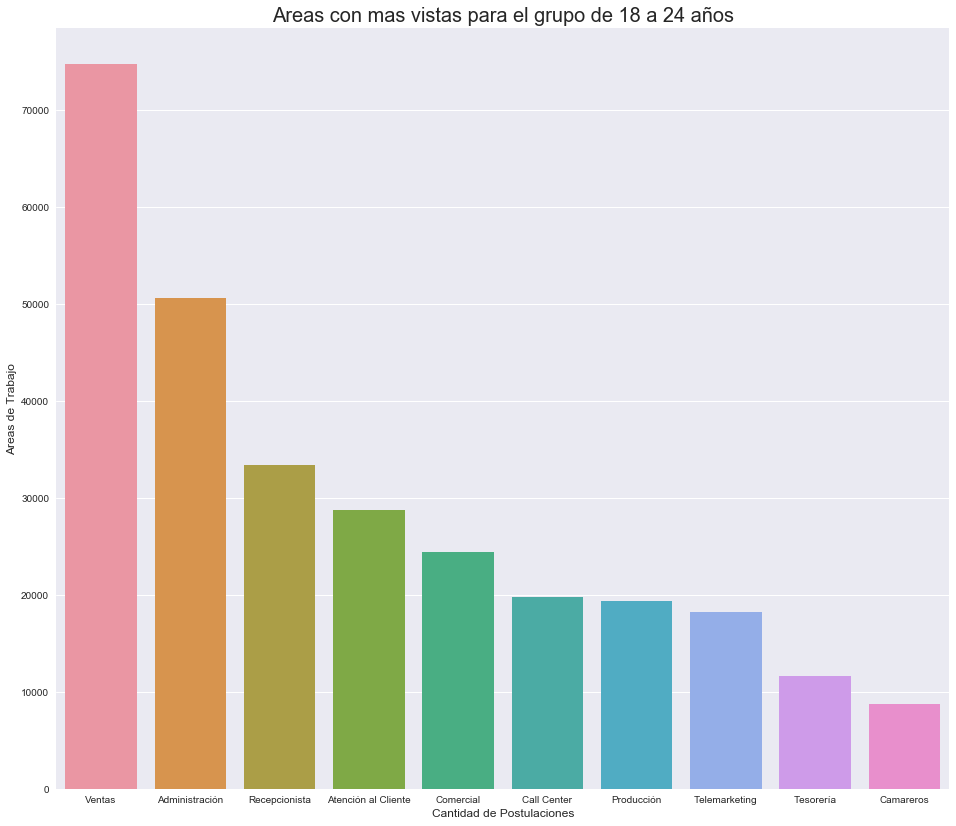

In [65]:
# Grafico que muestra las areas más vistadas para el grupo de 18 a 24 años.
plt.subplots(figsize = (16, 14))
areaMasVisitadas1Plot = sns.barplot(x = areaMasVisitadas1['nombre_area'], y = areaMasVisitadas1['cantidad'], orient = 'v')
areaMasVisitadas1Plot.set_title("Areas con mas vistas para el grupo de 18 a 24 años", fontsize = 20)
areaMasVisitadas1Plot.set_xlabel("Cantidad de Postulaciones", fontsize = 12)
areaMasVisitadas1Plot.set_ylabel("Areas de Trabajo", fontsize = 12)
plt.show()

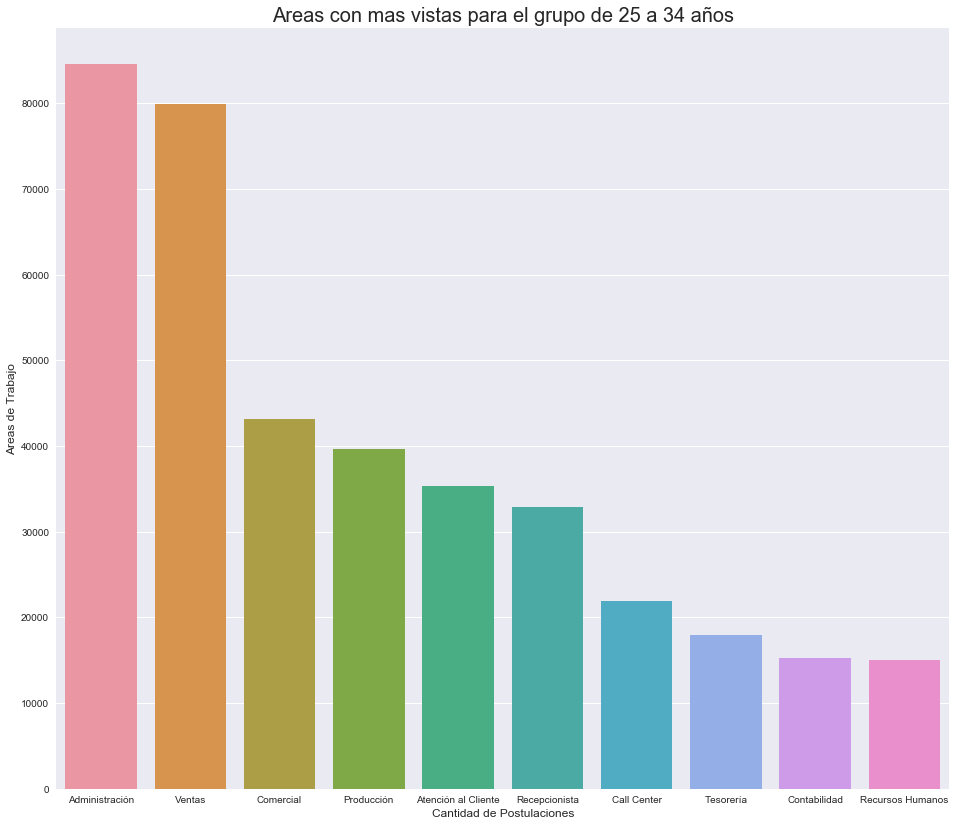

In [66]:
# Grafico que muestra las areas más vistadas para el grupo de 25 a 34 años.
plt.subplots(figsize = (16, 14))
areaMasVisitadas2Plot = sns.barplot(x = areaMasVisitadas2['nombre_area'], y = areaMasVisitadas2['cantidad'], orient = 'v')
areaMasVisitadas2Plot.set_title("Areas con mas vistas para el grupo de 25 a 34 años", fontsize = 20)
areaMasVisitadas2Plot.set_xlabel("Cantidad de Postulaciones", fontsize = 12)
areaMasVisitadas2Plot.set_ylabel("Areas de Trabajo", fontsize = 12)
plt.show()

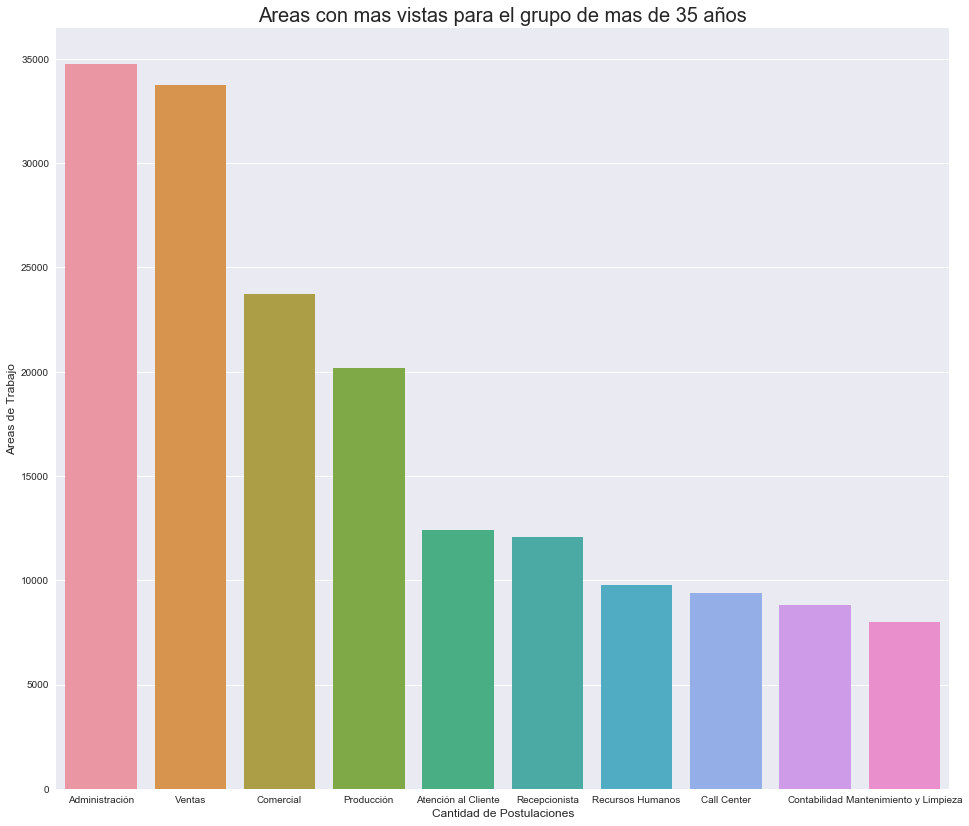

In [68]:
# Grafico que muestra las areas más vistadas para el grupo de mas de 35.
plt.subplots(figsize = (16, 14))
areaMasVisitadas3Plot = sns.barplot(x = areaMasVisitadas3['nombre_area'], y = areaMasVisitadas3['cantidad'], orient = 'v')
areaMasVisitadas3Plot.set_title("Areas con mas vistas para el grupo de mas de 35 años", fontsize = 20)
areaMasVisitadas3Plot.set_xlabel("Cantidad de Postulaciones", fontsize = 12)
areaMasVisitadas3Plot.set_ylabel("Areas de Trabajo", fontsize = 12)
plt.show()

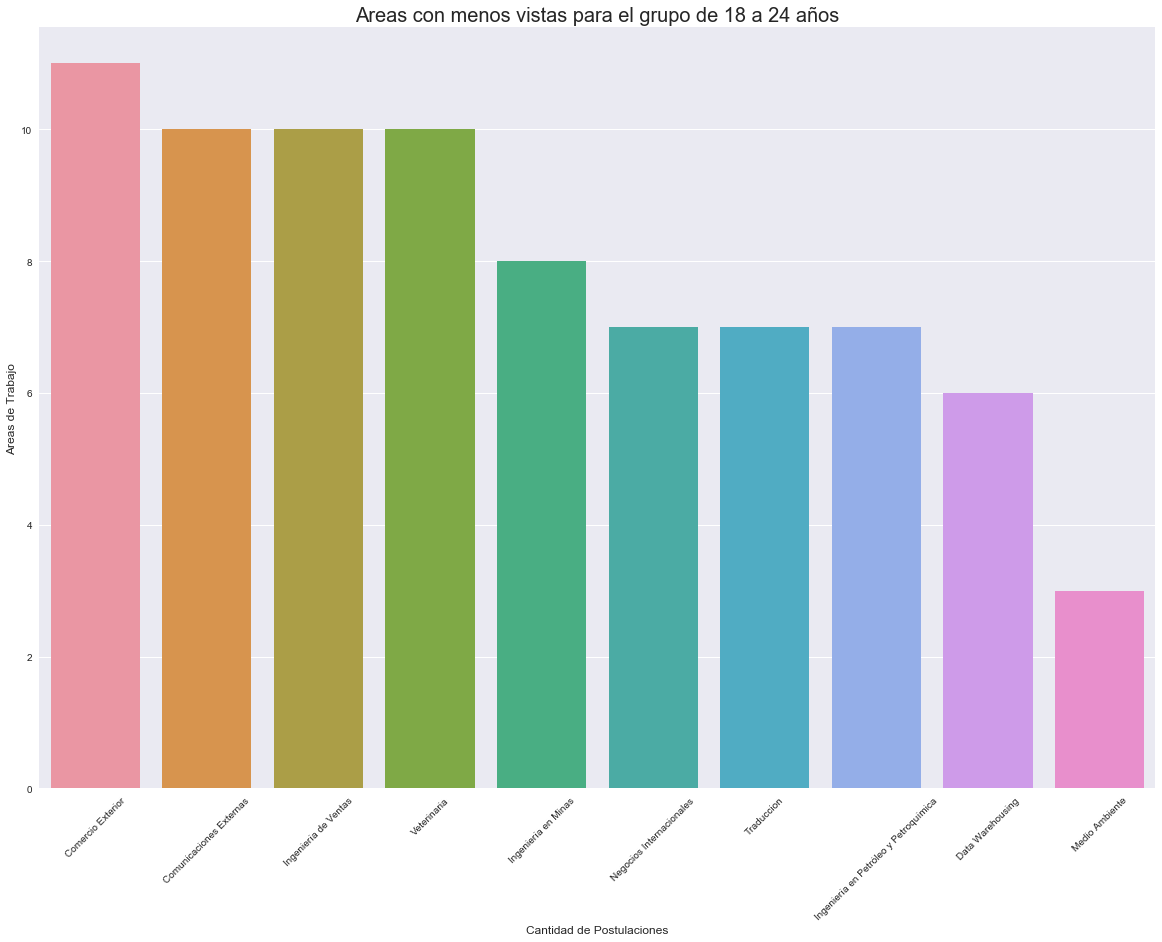

In [73]:
# Grafico que muestra las areas menos vistadas para el grupo de 18 a 24 años.
plt.subplots(figsize = (20, 14))
areaMenosVisitadas1Plot = sns.barplot(x = areaMenosVisitadas1['nombre_area'], y = areaMenosVisitadas1['cantidad'], orient = 'v')
areaMenosVisitadas1Plot.set_xticklabels(areaMenosVisitadas1Plot.get_xticklabels(), rotation = 45)
areaMenosVisitadas1Plot.set_title("Areas con menos vistas para el grupo de 18 a 24 años", fontsize = 20)
areaMenosVisitadas1Plot.set_xlabel("Cantidad de Postulaciones", fontsize = 12)
areaMenosVisitadas1Plot.set_ylabel("Areas de Trabajo", fontsize = 12)
plt.show()

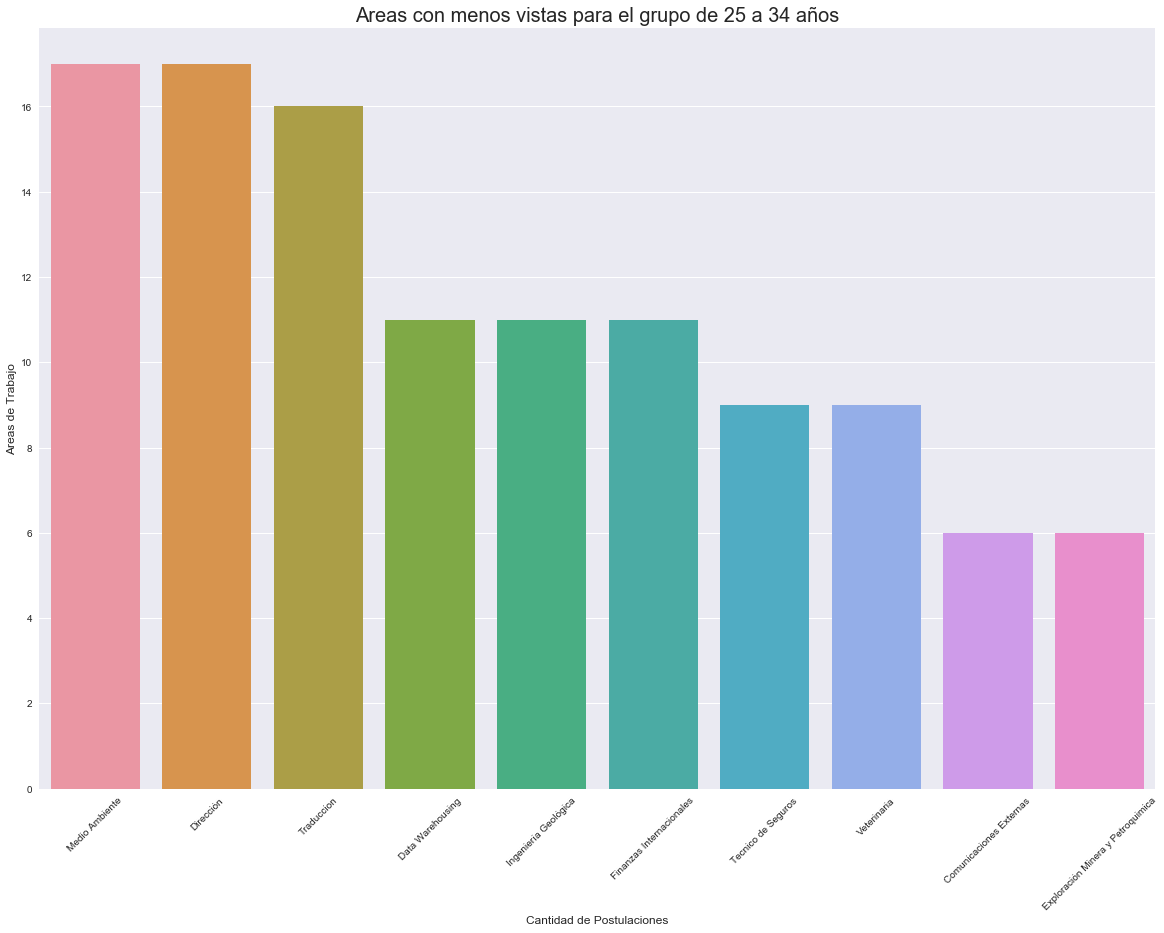

In [75]:
# Grafico que muestra las areas menos vistadas para el grupo de 25 a 34 años.
plt.subplots(figsize = (20, 14))
areaMenosVisitadas2Plot = sns.barplot(x = areaMenosVisitadas2['nombre_area'], y = areaMenosVisitadas2['cantidad'], orient = 'v')
areaMenosVisitadas2Plot.set_xticklabels(areaMenosVisitadas2Plot.get_xticklabels(), rotation = 45)
areaMenosVisitadas2Plot.set_title("Areas con menos vistas para el grupo de 25 a 34 años", fontsize = 20)
areaMenosVisitadas2Plot.set_xlabel("Cantidad de Postulaciones", fontsize = 12)
areaMenosVisitadas2Plot.set_ylabel("Areas de Trabajo", fontsize = 12)
plt.show()

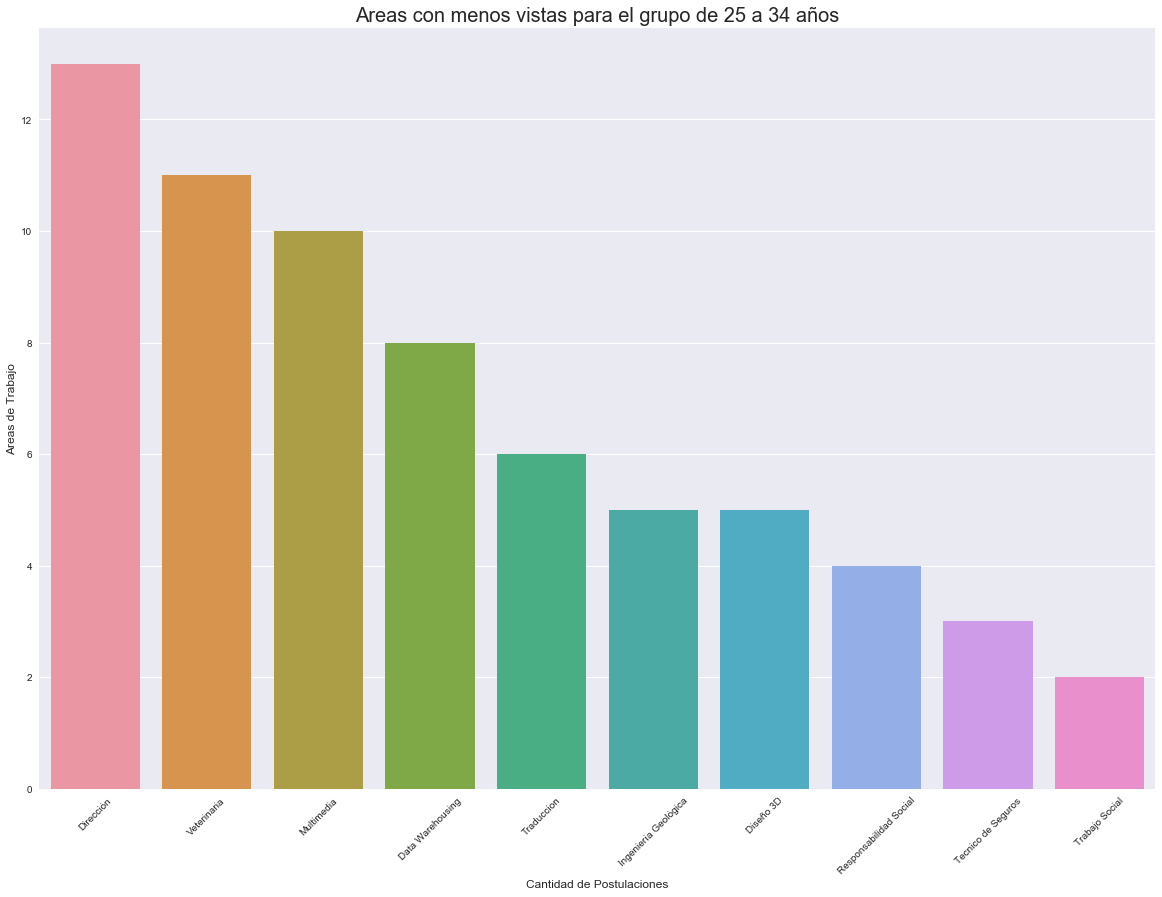

In [76]:
# Grafico que muestra las areas menos vistadas para el grupo de mas de 35 años.
plt.subplots(figsize = (20, 14))
areaMenosVisitadas3Plot = sns.barplot(x = areaMenosVisitadas3['nombre_area'], y = areaMenosVisitadas3['cantidad'], orient = 'v')
areaMenosVisitadas3Plot.set_xticklabels(areaMenosVisitadas3Plot.get_xticklabels(), rotation = 45)
areaMenosVisitadas3Plot.set_title("Areas con menos vistas para el grupo de 25 a 34 años", fontsize = 20)
areaMenosVisitadas3Plot.set_xlabel("Cantidad de Postulaciones", fontsize = 12)
areaMenosVisitadas3Plot.set_ylabel("Areas de Trabajo", fontsize = 12)
plt.show()